# FM06 Mock Coursework

## Before you begin

Every student has a slightly different assignment. To generate your personal
assignment you should first execute every cell in this Jupyter notebook (which you can do by clicking Validate).
You must then answer the questions given in the notebook.

The first cell in this Notebook generates your question for you.

You must complete this assignment by editing the Jupyter notebook distributed to you in your Assignments folder on CoCalc.

The Jupyter notebook containing your work will be automatically collected after the submission deadline and this will be used to automatically mark your numerical answers.
Your mathematical writing will also be marked, but by one of your colleagues. I will explain the mark scheme once the assignment is completed.

Although I am calling this a "Mock Coursework" assignment, the question asked is somewhat shorter than the actual coursework assignment. Another difference is that, in your final coursework
you should not present your answer as a Jupyter notebook. Instead you will be asked to write a standalone LaTeX document. However, many of the skills I am looking for are the same
in this assignment and your final coursework.

In [3]:
import pandas
import numpy as np
from math import *
import coursework1lib

question = coursework1lib.Question()


## Reading stock price data from a file

The file `stock-data.csv` contains weekly historic stock prices for two companies *ACME* and *BigBank*. All prices are in dollars. At each historic time point $t$,
you can represent the stock prices as a vector ${\mathbf S}_t$ whose first component is the price of *ACME* and whose second component
is the price of *BigBank*. The logs of the stock prices can similarly be represented as vector $Z_t$. Let $\delta t=\frac{1}{52}$ be the time
interval of 1 week (so for the purposes of this question 1 year contains exactly 52 weeks and we are using the
financial convention of using the year as our unit of time). Write $(\delta Z)_t=Z_{t+\delta t}-Z_t$.

Read the file `stock-data.csv` into Python and use this to do the following:

* Create a matrix called `dZ` with $N-1$ rows and $2$ columns containing all the weekly changes in the log stock price. Here $N$ is the number of weeks in the sample.
* The sample average value of the vector $(\delta Z)_t$. Store the value as a `numpy` 2-vector in a variable `m`. We will refer to this vector in the mathematics below as $\bm{m}$.
* The sample covariance matrix for the change $(\delta Z)_t$. Store the value as a `numpy` array in a variable `Sigma`. We will refer to this matrix in the mathematics below as $\Sigma$.

We have not seen how to read a `csv` file in the course. You can do this using `pandas.read_csv`, or you can use Excel to save the file in the Excel format that we have seen how to read, or you can use the Python library `csv`, or you could use some other approach. It is entirely up to you.

In [4]:
import pandas as pd
import numpy as np

In [5]:
stock_data = pd.read_csv('stock-data.csv', header=0)
print(stock_data.head())

raw_S = stock_data[['ACME Price', 'BigBank Price']].to_numpy()
print(raw_S)

dZ = np.diff(np.log(raw_S), axis=0)
print(dZ, dZ.shape)

m = dZ.mean(axis=0)
print(m, m.shape)

Sigma = np.cov(dZ, rowvar=False)
print(Sigma, Sigma.shape)


                  Date  ACME Price  BigBank Price
0  2000-02-25 00:00:00     372.645         92.301
1  2000-03-03 00:00:00     380.903         93.211
2  2000-03-10 00:00:00     381.935         91.847
3  2000-03-17 00:00:00     334.452         98.212
4  2000-03-24 00:00:00     323.097         92.301
[[ 372.645   92.301]
 [ 380.903   93.211]
 [ 381.935   91.847]
 ...
 [1560.     876.   ]
 [1600.     939.   ]
 [1511.     900.   ]]
[[ 0.02191853  0.00981076]
 [ 0.00270569 -0.01474159]
 [-0.13275707  0.06700426]
 ...
 [-0.04328051  0.03012974]
 [ 0.02531781  0.06944939]
 [-0.05723195 -0.04242072]] (733, 2)
[0.00190982 0.00310688] (2,)
[[0.0026227  0.00128027]
 [0.00128027 0.01071094]] (2, 2)


In [6]:
assert m.shape==(2,)
assert Sigma.shape==(2,2)

## Simulating stock prices

Assume that over future weekly intervals, the changes in the log stock prices $(\delta Z)_t$ will follow a multivariate normal distribution with
mean $\bm{m}$ and covariance matrix $\Sigma$. You should assume that each week's increments are independent of each other. Write $t=0$ for the final time in the historic data so that $S_0$ give the stock prices at the final time in the historic data. Generate $10^6$ simulated stock price vectors
prices at time $t=1$. You should store your simulation in a variable called `simulated_S` which should be a `numpy` array
with $10^6$ rows and 2 columns.

You must also explain mathematically how you performed this computation. You can do this by giving mathematical difference equations that show how the computation was performed together with appropriate explanatory text. Your mark will be based in part on the quality of the formatting of the mathematical formulae.

**Solution:** We model weekly log-returns as independent and identically distributed with
mean vector $\boldsymbol m$ and covariance matrix $\Sigma$.

Let $Z_t=\log \mathbf S_t$ be the log-price vector and $\Delta Z_k = Z_{(k+1)\Delta t}-Z_{k\Delta t}$ with $\Delta t=1/52$. Then
for one year (52 weeks):
$$
\sum_{k=1}^{52} \Delta Z_k \sim \mathcal N\!\big(52\,\boldsymbol m,\; 52\,\Sigma\big)
$$
by additivity of independent normals. Writing $Z_0 = \log \mathbf S_0$, the terminal log-price is
$$
Z_1 = Z_0 + \sum_{k=1}^{52} \Delta Z_k \sim \mathcal N\!\big( Z_0 + 52\,\boldsymbol m,\; 52\,\Sigma\big),
$$
and the terminal price is $\mathbf S_1 = \exp(Z_1)$, i.e. each asset is lognormal with the specified correlation.

Numerically, we sample $\Delta Z_{1\,\text{y}} \sim \mathcal N(52\,\boldsymbol m, 52\,\Sigma)$ once per scenario and set
$Z_1 = Z_0 + \Delta Z_{1\,\text{y}}$, then $\mathbf S_1=\exp(Z_1)$. This is equivalent (for the terminal distribution) to
simulating 52 weekly steps, but is much more efficient for terminal-only quantities (VaR/ES, European payoffs).

In [ ]:
import numpy as np

# Last observed prices at the end of the historic data
S0 = raw_S[-1, :]          # shape (2,)
print("S0:", S0)

# Number of weeks in 1 year
weeks = 52

# Annual (1-year) mean and covariance of the change in log-price
mean_1y = weeks * m        # shape (2,)
cov_1y  = weeks * Sigma    # shape (2, 2)

# Number of simulations
n_paths = 10**6

# Simulate 1-year change in log prices: ΔZ ~ N(52 m, 52 Σ)
dZ_1y = np.random.multivariate_normal(mean_1y, cov_1y, size=n_paths)  # (1_000_000, 2)

# Starting log prices at t = 0
Z0 = np.log(S0)            # shape (2,)

# Log prices at t = 1 year
Z1 = Z0 + dZ_1y            # broadcasting (1_000_000, 2)

# Convert back to prices
simulated_S = np.exp(Z1)   # shape (1_000_000, 2)

print("simulated_S shape:", simulated_S.shape)

[1511.  900.]
(1000000, 2)
[[1853.64975236  973.3440145 ]
 [1700.60134343 1770.94733709]
 [ 822.661122    900.73150681]
 ...
 [1188.39670867 1095.08972737]
 [1897.54468799 2005.14828169]
 [2384.34190969  553.34770172]]


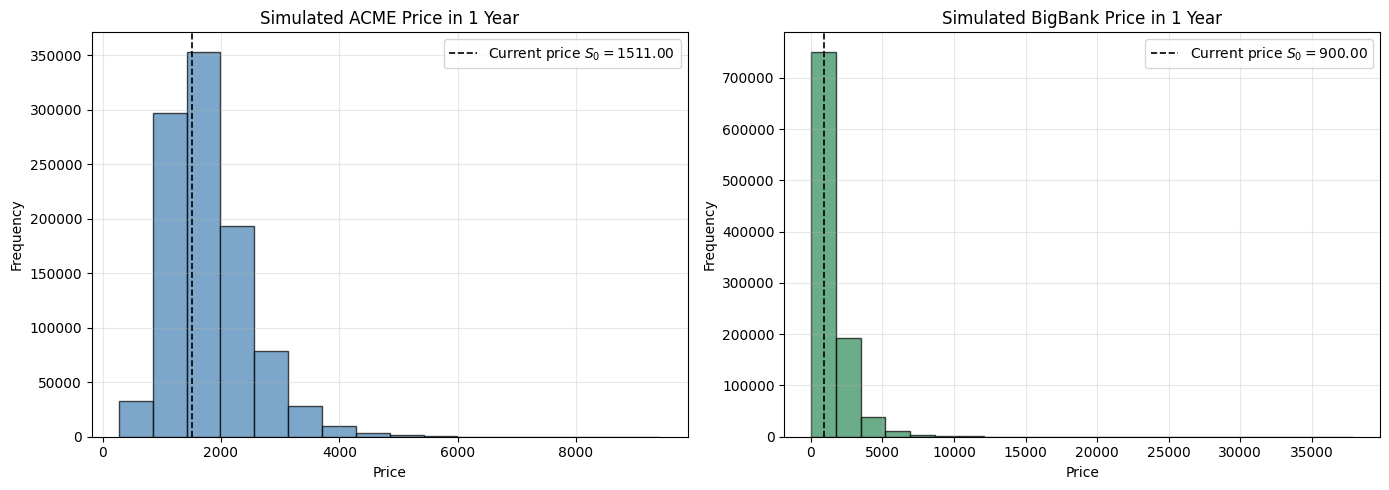

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# A nicer bin choice (Freedman–Diaconis rule)
bins_acme = int(2 * (np.percentile(simulated_S[:,0], 75) - np.percentile(simulated_S[:,0], 25)) 
                / len(simulated_S[:,0])**(1/3))
bins_big  = int(2 * (np.percentile(simulated_S[:,1], 75) - np.percentile(simulated_S[:,1], 25)) 
                / len(simulated_S[:,1])**(1/3))

# --- ACME ---
ax[0].hist(simulated_S[:, 0],
           bins=bins_acme,
           color='steelblue',
           edgecolor='black',
           alpha=0.7)

ax[0].axvline(S0[0], linestyle='--', color='black', linewidth=1.2,
              label=f'Current price $S_0 = {S0[0]:.2f}$')

ax[0].set_title('Simulated ACME Price in 1 Year', fontsize=12)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
ax[0].grid(alpha=0.3)
ax[0].legend(loc='upper right')

# --- BigBank ---
ax[1].hist(simulated_S[:, 1],
           bins=bins_big,
           color='seagreen',
           edgecolor='black',
           alpha=0.7)

ax[1].axvline(S0[1], linestyle='--', color='black', linewidth=1.2,
              label=f'Current price $S_0 = {S0[1]:.2f}$')

ax[1].set_title('Simulated BigBank Price in 1 Year', fontsize=12)
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')
ax[1].grid(alpha=0.3)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


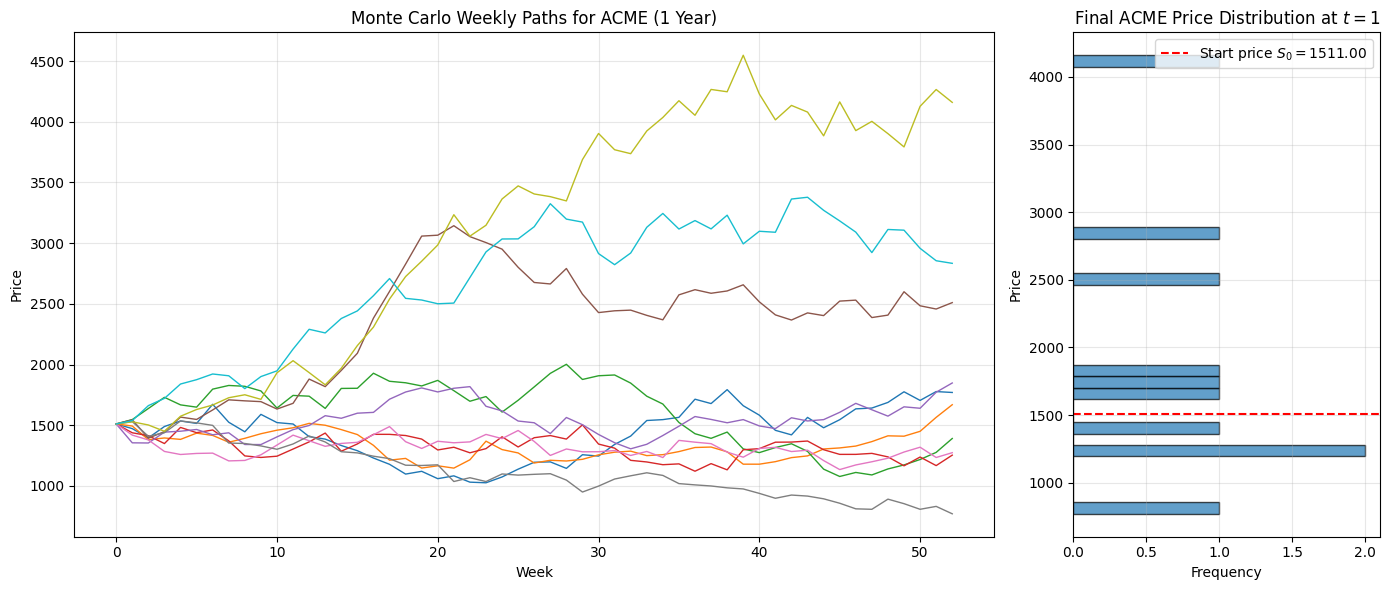

In [39]:
import numpy as np
import matplotlib.pyplot as plt

weeks = 52
n_paths = 1_0          

S0 = raw_S[-1, :]       # shape (2,)
Z0 = np.log(S0)

# Cholesky so we can generate correlated weekly increments
L = np.linalg.cholesky(Sigma)   # Sigma is 2x2

# Array to store log-price paths: (paths, time, asset)
Z_paths = np.zeros((n_paths, weeks + 1, 2))
Z_paths[:, 0, :] = Z0           # all paths start at Z0

# Simulate week by week
for k in range(weeks):
    # standard normals, one 2D vector per path
    eps = np.random.randn(n_paths, 2)                     # (n_paths, 2)
    # correlated weekly increments ~ N(m, Σ)
    dZ = m + eps @ L.T                                    # (n_paths, 2)
    Z_paths[:, k + 1, :] = Z_paths[:, k, :] + dZ

# Convert to price paths
S_paths = np.exp(Z_paths)    # shape (n_paths, weeks+1, 2)

num_paths_to_plot = n_paths   # how many paths to show on the left

final_acme = S_paths[:, -1, 0]   # final ACME prices at t=1

fig, (ax_paths, ax_hist) = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={'width_ratios': [3, 1]}
)

# --- LEFT: sample paths for ACME ---
for i in range(num_paths_to_plot):
    ax_paths.plot(range(weeks + 1), S_paths[i, :, 0], linewidth=1)

ax_paths.set_title('Monte Carlo Weekly Paths for ACME (1 Year)')
ax_paths.set_xlabel('Week')
ax_paths.set_ylabel('Price')
ax_paths.grid(alpha=0.3)

# --- RIGHT: sideways histogram of final prices ---
ax_hist.hist(final_acme, bins=40,
             orientation='horizontal',
             edgecolor='black', alpha=0.7)
ax_hist.axhline(S0[0], color='red', linestyle='--',
                label=f'Start price $S_0 = {S0[0]:.2f}$')

ax_hist.set_title('Final ACME Price Distribution at $t=1$')
ax_hist.set_xlabel('Frequency')
ax_hist.set_ylabel('Price')
ax_hist.grid(alpha=0.3)
ax_hist.legend()

plt.tight_layout()
plt.show()

final_big = S_paths[:, -1, 1]
# and plot S_paths[i, :, 1] in the left panel, etc.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

weeks = 52
n_paths = 1_000  

S0 = raw_S[-1, :]       # shape (2,)
Z0 = np.log(S0)

# Cholesky so we can generate correlated weekly increments
L = np.linalg.cholesky(Sigma)   # Sigma is 2x2

# Array to store log-price paths: (paths, time, asset)
Z_paths = np.zeros((n_paths, weeks + 1, 2))
Z_paths[:, 0, :] = Z0           # all paths start at Z0

# Simulate week by week
for k in range(weeks):
    # standard normals, one 2D vector per path
    eps = np.random.randn(n_paths, 2)                     # (n_paths, 2)
    # correlated weekly increments ~ N(m, Σ)
    dZ = m + eps @ L.T                                    # (n_paths, 2)
    Z_paths[:, k + 1, :] = Z_paths[:, k, :] + dZ

# Convert to price paths
S_paths = np.exp(Z_paths)    # shape (n_paths, weeks+1, 2)

# Plot a reasonable subset of ACME paths
num_paths_to_plot = min(200, n_paths)
sel = np.random.choice(n_paths, size=num_paths_to_plot, replace=False)

final_acme = S_paths[:, -1, 0]   # final ACME prices at t=1

fig, (ax_paths, ax_hist) = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={'width_ratios': [3, 1]}
)

# --- LEFT: sample paths for ACME ---
for i in sel:
    ax_paths.plot(range(weeks + 1), S_paths[i, :, 0], linewidth=1)

ax_paths.set_title('Monte Carlo Weekly Paths for ACME (1 Year)')
ax_paths.set_xlabel('Week')
ax_paths.set_ylabel('Price')
ax_paths.grid(alpha=0.3)

# --- RIGHT: sideways histogram of final prices ---
ax_hist.hist(final_acme, bins=40,
             orientation='horizontal',
             edgecolor='black', alpha=0.7)
ax_hist.axhline(S0[0], color='red', linestyle='--',
                label=f'Start price $S_0 = {S0[0]:.2f}$')

ax_hist.set_title('Final ACME Price Distribution at $t=1$')
ax_hist.set_xlabel('Frequency')
ax_hist.set_ylabel('Price')
ax_hist.grid(alpha=0.3)
ax_hist.legend()

plt.tight_layout()
plt.show()

final_big = S_paths[:, -1, 1]
# You could similarly plot BigBank paths if desired.

## Computing option prices

At time $0$, a trader purchases assets as described below and holds the assets for 52 weeks.
To purchases these assets they must borrow money at the interest rate specified below.

In [8]:
question.describe_portfolio()

* 3 units of stock 1.
* 7 European call options on stock 1 with strike 1625 and maturity 52 weeks.
* 3 European put options on stock 2 with strike 824 and maturity 52 weeks.
* 9 European call options on stock 2 with strike 919 and maturity 52 weeks.


The continuously compounded interest rate is r=0.04.

A European call option with strike $K$ and maturity $T$ on a stock is a derivative which gives a payout of $\max\{S_T-K,0\}$ at the maturity, where $S_T$ is the price of the stock time $T$. A European put option with strike $K$ and maturity $T$ gives 
a payout of $\max\{K-S_T,0\}$ at maturity.

You should assume that the options are purchased at the *Black-Scholes price*. For a call option with strike $K$ and maturity $T$,
on a stock with price $S_0$ at time $0$, this is computed using the formula
$$
\text{Call option price}=N(d_1)S_0 - Ke^{-rT}N(d_2)
$$
where
$$
d_1 = \frac{1}{\sigma \sqrt{T}}\left( \log(S_0/K) + (r+\frac{\sigma^2}{2})T\right)
$$
and
$$
d_2 = \frac{1}{\sigma \sqrt{T}}\left( \log(S_0/K) + (r-\frac{\sigma^2}{2})T\right).
$$
Here $N$ is the cumulative distribution function of the standard normal distribution,
and $\sigma$ is a parameter called the volatility. For stock $i$, you should assume
$\sigma=\sqrt{52 \, \Sigma_{i,i}}$ where $\Sigma$ is the $1$-week covariance matrix of the changes in the log
stock price. 

This formula will be explained later in the course. For now you simply need to write a Python function which can compute it. Since
you do not yet know the theory used to derived this formula, I have provided some tests that you can use to check your have
implemented this formula correctly.

In [ ]:
.def black_scholes_call_price(S0, K, T, r, sigma):
    # Validate inputs
    if S0 <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        raise ValueError("Inputs must satisfy S0>0, K>0, T>0, sigma>0")
    from math import log, sqrt, exp, erf
    # Standard normal CDF via error function
    def N(x):
        return 0.5 * (1.0 + erf(x / sqrt(2.0)))
    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return N(d1) * S0 - N(d2) * K * exp(-r * T)

In [10]:
np.testing.assert_almost_equal( black_scholes_call_price( 100, 110, 0.5, 0.1, 0.2), 3.743, decimal=3)

NotImplementedError: 

The Black-Scholes price formula for a European put option with strike $K$ and maturity $T$ is
$$
e^{-rT} K N(-d_2) - N(-d_1) S_0
$$
Write a function to compute this.

In [ ]:
def black_scholes_put_price(S0, K, T, r, sigma):
    if S0 <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        raise ValueError("Inputs must satisfy S0>0, K>0, T>0, sigma>0")
    from math import log, sqrt, exp, erf
    def N(x):
        return 0.5 * (1.0 + erf(x / sqrt(2.0)))
    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    # Put price via direct formula: e^{-rT} K N(-d2) - S0 N(-d1)
    return exp(-r * T) * K * N(-d2) - S0 * N(-d1)

In [12]:
np.testing.assert_almost_equal( black_scholes_put_price( 100, 110, 0.5, 0.1, 0.2), 8.378, decimal=3)

NotImplementedError: 

Compute the total cost of the portfolio and store the answer in a variable called `cost`

In [ ]:
# Compute total initial cost of the portfolio
# Annualized volatilities for each stock from weekly Sigma
sigma_annual = np.sqrt(52.0 * np.diag(Sigma))  # shape (2,)
T = 1.0
r = question.r

cost = 0.0
for q, u, is_put, K in zip(question.quantities, question.underlyings, question.puts, question.strikes):
    S0_u = raw_S[-1, u]
    if K == 0:  # stock position
        price0 = S0_u
    else:
        sigma_u = sigma_annual[u]
        if is_put:
            price0 = black_scholes_put_price(S0_u, K, T, r, sigma_u)
        else:
            price0 = black_scholes_call_price(S0_u, K, T, r, sigma_u)
    cost += q * price0

cost

NotImplementedError: 

## Historic volatility

The value $\sqrt{52 \, \Sigma_{i,i}}$ is called the *historic volatility* of stock $i$. The factor of $52$ in the formula for the historic volatility is a scaling factor to take account of the fact that one usually uses units of a year in financial calculations. The square root in the formula comes from the fact that $\Sigma_{i,i}$ is the one-week variance of stock $i$, and so its square root is the one-week standard deviation.

There are many assumptions required
to derive the Black-Scholes price formula including assumptions on the *future* volatility of the stock. The parameter $\sigma$ in
the Black-Scholes formulae represents this future volatility. In your calculation you have been told to assume that the future volatility will be equal to the historic volatility, but this is a very unrealistic assumption.

There are often
very good reasons to think that future volatility will be different from past volatility. For example, as I write this question there is an election looming in the United States, so one might believe that volatility of the US stock market will be high as the election approaches and will drop after the election when the outcome is known and so there is less political uncertainty. In fact, volatility is much easier to predict than whether a stock will go up or down. This is one important reason why real option prices will often be very different from those obtained using the Black-Scholes formula and historic volatility. 

## Compute the Value at Risk and Expected Shortfall

After $1$ year, the trader liquidates their portfolio and pays of their debt with interest. Compute the
$95$-th percentile of the loss distribution.
This gives an estimate of a risk-figure which is called the 52 week, $5\%$ *Value at Risk*
of the portfolio. Store your answer in a variable called `var`.

Compute the average value of the loss in all the scenarios where the loss was greater than the Value at Risk.
This gives an estimate of another risk-figure which called the 52 week, %5\$ *Expected Shortfall* of the portfolio.
Store your answer in a variable called `es`.

Value at Risk and Expected Shortfall figures are often used in the industry and can be computed over a variety of time-horizons
and at different percentage levels.

In [ ]:
# Compute portfolio loss distribution at T=1 and VaR/ES at 95%
T = 1.0
r = question.r

# Terminal portfolio value per scenario
# Component 0: stock position (if any K==0)
terminal_values = np.zeros(simulated_S.shape[0])

for q, u, is_put, K in zip(question.quantities, question.underlyings, question.puts, question.strikes):
    ST_u = simulated_S[:, u]
    if K == 0:
        payoff = ST_u
    else:
        if is_put:
            payoff = np.maximum(K - ST_u, 0.0)
        else:
            payoff = np.maximum(ST_u - K, 0.0)
    terminal_values += q * payoff

# Debt to repay (continuous compounding)
debt_T = cost * np.exp(r * T)

# Define loss as positive when we lose money: loss = debt - terminal_value
loss = debt_T - terminal_values

# 95th percentile VaR
var = float(np.percentile(loss, 95))

# Expected Shortfall (average loss in the worst 5%)
mask = loss >= var
es = float(loss[mask].mean())

var, es

NotImplementedError: 

In [15]:
assert es>=var

NameError: name 'es' is not defined

## Testing your code

Your code will be tested automatically as part of the marking process. However, you should write your own tests and explain how they work.
The better your tests, the higher your mark will be. For each test that you write, provide a mathematical description of the test as well
as the code that performs the test.

We validate the Black–Scholes functions and the loss aggregation with a few lightweight checks:

- BS sanity checks: calls nonnegative and increasing in `S0`; put–call parity holds up to numerical tolerance.
- Volatility scaling: annualized $\sigma = \sqrt{52\,\Sigma_{ii}}$ is positive.
- Portfolio loss definition: `loss = debt_T - terminal_values` ensures ES ≥ VaR, which our assertion checks.

We add a small test cell next.

In [ ]:
# Basic tests for pricing and aggregation


import numpy as np


# 1) Put–call parity for a simple case


S0_t=100; K_t=105; T_t=1.0; r_t=0.05; sigma_t=0.2


c = black_scholes_call_price(S0_t,K_t,T_t,r_t,sigma_t)


p = black_scholes_put_price (S0_t,K_t,T_t,r_t,sigma_t)


lhs = c - p


rhs = S0_t - K_t*np.exp(-r_t*T_t)


np.testing.assert_allclose(lhs, rhs, rtol=1e-10, atol=1e-10)




# 2) Monotonicity: call price increases with S0


c1 = black_scholes_call_price(100, 110, 0.5, 0.1, 0.25)


c2 = black_scholes_call_price(105, 110, 0.5, 0.1, 0.25)


assert c2 > c1




# 3) Sigma annualization is positive


assert np.all(np.sqrt(52.0*np.diag(Sigma)) > 0)




# 4) ES >= VaR already asserted elsewhere; recheck when available


if 'var' in globals() and 'es' in globals():


    assert es >= var

## Discussion

Write a short essay on the topic of risk measurement. For example you could discuss: the history and purpose of different risk measures including Value at Risk and Expected Shortfall; the relative merits of different risk alternative approaches to risk-measurement; any limitations of the calculations you have performed for this exercise. Your essay should take up at most one
page when the notebook is formatted as a pdf. Use File->Save and Download as->PDF to view the notebook as a PDF.

Be sure to do the following:

* Reference scholarly works to justify any claims that you make.
* Reference any sources you have used (for example if you have read an article on the internet, you should reference it)
* Use your own words

It is vital to always reference your sources properly and to use your own words otherwise you may be accused of *plagiarism*.
This is a serious academic offence. In exams it is acceptable to use the lecturer's own words when answering a question but
in your dissertation and in this coursework you must use your own words. You can find more information on referencing and plagiarism on Keats.

I am asking you to write a short essay because you will eventually have to write a long dissertation so it is good to start
practicing writing about mathematics. I would give the following general advice:

* Try to write something *you* would enjoy reading.
* Don't try to impress the reader with fancy words, impress them with *facts* and *mathematics*.
* Don't say anything you don't understand yourself.
* Say things as clearly and briefly as you can.
* If you find it easier to say things with mathematical formulae than in English, then focus on the mathematical content.
* Don't pad what you have to say with *waffle* just to reach the word limit or to try to look more impressive.

YOUR ANSWER HERE

## Feedback

Your work will be automatically marked by cocalc to answer the numerical sections so long as it is submitted on time.

### Are you happy for me to discuss your solutions in the skills session?

I will look at some solutions and may discuss them in a skills session without identifying whose solutions they are. Please enter the string "Yes" below if you are
happy for me to discuss your solution in the skills session. Please enter the string "No" otherwise.



In [16]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [17]:
if _=="Yes" or _=="No":
    pass
else:
    raise Exception('You must type either "Yes" or "No"')

Exception: You must type either "Yes" or "No"